In [1]:
import nbimporter
import numpy as np

import s03_01_hc_load_general as ld

import s04_07_a_kerosene_boiler as hs_oil
import s04_07_b_gas_boiler as hs_gas
import s04_07_c_electric_heater as hs_eheater
import s04_07_d_electric_heatpump as hs_ehpump
import s04_07_e_hybrid_hw_gas_ht_hybrid as hs_gas_hybrid
import s04_07_f_hybrid_hw_hybrid_ht_gas as hs_hybrid_gas
import s04_07_g_hybrid_hw_hybrid_ht_hybrid as hs_whybrid
import s04_07_n as hs_ghpump

import s04_07_j_panel_radiator as rad_panel
import s04_07_k_fan_convector as rad_fanc
import s04_07_l_hot_water_floor_heating as rad_floor

import s04_07_i_pipe as pipe

from s04_07_common import get_Q_out_H_hs_d_t

from s11_01_external_condition import \
    load_outdoor, \
    get_Theta_ex, \
    get_X_ex, \
    calc_h_ex, \
    get_Theta_ex_a_Ave, \
    get_Theta_ex_d_Ave_d, \
    get_Theta_ex_H_Ave

## 第七節　温水暖房 / Section 7 Hot Water Heating

1．適用範囲～4．記号及び単位は省略

1. Scope of application ~ 4. Symbols and units are omitted

### 5. 最大暖房出力 / Maximum heating output

日付$d$の時刻$t$における 1 時間当たりの暖冷房区画$i$に設置された暖房設備機器等の最大暖房出力$Q_{max,H,d,t,i}$は、日付$d$の時刻$t$における 1 時間当たりの暖冷房区画$i$に設置された放熱器の最大暖房出力$Q_{max,H,rad,d,t,i}$に等しいとする。 

Maximum heating output $ Q_{max, H, d, t, i} $ of heating equipment installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $ is $ $ It is assumed that the maximum heating output $ Q_{max, H, rad, d, t, i} $ of the radiator installed in the heating / cooling section $ i $ per hour at time $ t $ of d $.

In [2]:
def calc_Q_max_H_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type):
    """ 最大暖房出力

    :param radiator: 放熱器仕様
    :type radiator: dict
    :param A_HCZ: 暖冷房区画の床面積
    :type A_HCZ: float
    :param Theta_SW: 往き温水温度
    :type Theta_SW: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode: 運転モード 'い', 'ろ', 'は'
    :type mode: str
    :param R_type: 居室の形式
    :type R_type: string
    :return: 最大暖房出力
    :rtype: ndarray
    """
    return calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type)


### 6. エネルギー消費量 / Energy consumption

#### 6.1 消費電力量 / Power consumption

$$
\large
E_{E,H,d,t} = E_{E,hs,d,t} + \sum_{i} (E_{E,rad,d,t,i})
$$

$E_{E,H,d,t}$：日付$d$の時刻$t$における1時間当たりの消費電力量(kWh/h) / Power consumption per hour at time $ t $ of date $ d $  
$E_{E,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機の消費電力量(kWh/h) / Power consumption of the hot water heating heater per hour at time $ t $ on date $ d $  
$E_{E,rad,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された放熱器の消費電力量(kWh/h) / Power consumption of radiator installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $    

In [3]:
def calc_E_E_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, L_CS_x_t, L_CL_x_t, CG=None):
    """ 消費電力量 (1)

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param L_CS_x_t: 暖冷房区画の冷房顕熱負荷
    :type L_CS_x_t: ndarray
    :param L_CL_x_t: 暖冷房区画の冷房潜熱負荷
    :type L_CL_x_t: ndarray
    :param CG: コージェネレーション設備の仕様
    :type CG: dict
    :return: 消費電力量 (1)
    :rtype: ndarray
    """
    rad_types = get_rad_type_list()

    rad_list = get_rad_list(H_MR, H_OR)

    E_E_hs_d_t = calc_E_E_hs_d_t(H_HS, H_MR, H_OR, region, A_A, A_MR, A_OR, mode_MR, mode_OR, L_T_H_rad, CG, L_CS_x_t, L_CL_x_t)

    E_E_rad_d_t = np.zeros((5, 24 * 365))
    for i in [1, 3, 4, 5]:
        if rad_list[i - 1] is None:
            continue
        if rad_list[i - 1]['type'] in rad_types:
            radiator = rad_list[i - 1]
            R_type = '主たる居室' if i == 1 else 'その他の居室'
            mode = mode_MR if i == 1 else mode_OR
            A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)

            Theta_SW_hs_op = get_Theta_SW_hs_op(H_HS['type'], CG)
            p_hs_d_t = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
            Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs_d_t)
            Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW_d_t, region, mode, R_type)
            Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

            E_E_rad_d_t_i = calc_E_E_rad_d_t_i(i, radiator, Q_T_H_rad_d_t_i, Theta_SW_d_t, A_A, A_MR, A_OR, region, mode,
                                               R_type)
            E_E_rad_d_t[i - 1, :] = E_E_rad_d_t_i

            # print('{} E_E_rad_d_t_{} = {} [KWh] (L_T_H_rad_d_t_{} = {} [MJ])'.format(radiator['type'], i,
            #                                                                          np.sum(E_E_rad_d_t_i), i,
            #                                                                          np.sum(L_T_H_rad[i - 1])))

    E_E_H_d_t = E_E_hs_d_t + np.sum(E_E_rad_d_t, axis=0)

    return E_E_H_d_t

#### 6.2 灯油消費量 / Kerosene consumption

$$
\large
E_{K,H,d,t} = E_{K,hs,d,t}
$$

$E_{K,H,d,t}$：日付$d$の時刻$t$における1時間当たりの灯油消費量(MJ/h) / Kerosene consumption per hour at time $ t $ of date $ d $  
$E_{K,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機の灯油消費量(MJ/h) / Kerosene consumption of the heat source machine for hot water heating per hour at the time $ t $ of date $ d $ 

In [4]:
def calc_E_K_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ 灯油消費量 (2)

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :return: 灯油消費量 (2)
    :rtype: ndarray
    """
    return calc_E_K_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

#### 6.3 ガス消費量 / Gas consumption

$$
\large
E_{G,H,d,t} = E_{G,hs,d,t}
$$

$E_{G,H,d,t}$：日付$d$の時刻$t$における1時間当たりのガス消費量(MJ/h) / Gas consumption per hour at time $ t $ of date $ d $  
$E_{G,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機のガス消費量(MJ/h) / Gas consumption of the hot water heating heat source machine per hour at time $ t $ of date $ d $  

In [5]:
def calc_E_G_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ ガス消費量 (3)

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :return: ガス消費量 (3)
    :rtype: ndarray
    """
    return calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

#### 6.4 その他の燃料による一次エネルギー消費量 / Primary energy consumption by other fuels

$$
\large
E_{M,H,d,t} = E_{M,hs,d,t}
$$

$E_{M,H,d,t}$：日付$d$の時刻$t$における1時間当たりのその他の燃料による一次エネルギー消費量(MJ/h) / Primary energy consumption by other fuels per hour at time $ t $ on date $ d $  
$E_{M,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機のその他の燃料による一次エネルギー消費量(MJ/h) / Primary energy consumption by the other fuels of the hot water heating heat source unit per hour at time $ t $ of date $ d $  

In [6]:
def calc_E_M_H_d_t(H_HS):
    """ その他の燃料による一次エネルギー消費量 (4)

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :return: その他の燃料による一次エネルギー消費量 (4)
    :rtype: ndarray
    """
    return get_E_M_hs_d_t(H_HS)

### 7. 温水暖房用熱源機のエネルギー消費量 / Energy consumption of heat source equipment for hot water heating

In [7]:
def calc_Q_UT_hs_d_t(H_HS, H_MR, H_OR, region, A_A, A_MR, A_OR, mode_MR, mode_OR, L_T_H_rad, CG, L_CS_x_t_i, L_CL_x_t_i):
    """ 温水暖房用熱源機の未処理

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :param L_CS_x_t_i: 日付dの時刻tにおける暖冷房区画iの冷房顕熱負荷 (MJ/h)
    :type L_CS_x_t_i: ndarray
    :param L_CL_x_t_i: 日付dの時刻tにおける暖冷房区画iの冷房潜熱負荷 (MJ/h)
    :type L_CL_x_t_i: ndarray
    :return: 温水暖房用熱源機の未処理
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換
    rad_list = get_rad_list(H_MR, H_OR)

    # 温水暖房用熱源機の往き温水温度
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    # 温水暖房用熱源機の温水熱需要
    Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                         Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                         mode_MR, mode_OR, L_T_H_rad)

    # 処理暖房負荷
    Q_T_H_rad = np.zeros((5, 24 * 365))
    for i in [1, 3, 4, 5]:

        if rad_list[i - 1] is None:
            continue

        # 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
        R_type = '主たる居室' if i == 1 else 'その他の居室'
        mode = mode_MR if i == 1 else mode_OR
        Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

        # 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
        Q_T_H_rad[i - 1, :] = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

    # 温水暖房用熱源機の温水供給運転率
    r_WS_hs = calc_r_WS_hs_d_t(rad_list, Q_dmd_H_hs_d_t, Q_T_H_rad, Theta_SW_d_t, region, A_A, A_MR, A_OR, mode_MR)

    if hs_type in ['石油温水暖房機', '石油給湯温水暖房機', '石油従来型温水暖房機', '石油従来型給湯温水暖房機', '石油潜熱回収型温水暖房機', '石油潜熱回収型給湯温水暖房機']:

        # 定格効率
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_oil.get_e_rtd_default(hs_type)

        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 温水暖房熱源機の定格能力
        q_rtd_hs = hs_oil.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # 最大暖房出力
        Q_max_H_hs_d_t = hs_oil.get_Q_max_H_hs(q_rtd_hs)

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs
    elif hs_type in ['ガス温水暖房機', 'ガス給湯温水暖房機', 'ガス従来型温水暖房機', 'ガス従来型給湯温水暖房機', 'ガス潜熱回収型温水暖房機', 'ガス潜熱回収型給湯温水暖房機']:

        # 定格効率
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_gas.get_e_rtd_default(hs_type)

        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 温水暖房熱源機の定格能力
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # 最大暖房出力
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs
    elif hs_type == '電気ヒーター温水暖房機' or hs_type == '電気ヒーター給湯温水暖房機':
        # 最大出力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 最大出力
        Q_max_H_hs_d_t = hs_eheater.calc_Q_max_H_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t
    elif hs_type == '電気ヒートポンプ温水暖房機':
        # 定格の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 定格能力
        q_rtd_hs = hs_ehpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # 外気条件の取得
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # 最大出力
        Q_max_H_hs_d_t = hs_ehpump.calc_Q_max_H_hs(
            q_rtd_hs=q_rtd_hs,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            h_ex=h_ex
        )

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return np.zeros(24 * 365)
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)':
        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 温水暖房熱源機の定格能力
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # 最大暖房出力
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return np.zeros(24 * 365)
    elif hs_type == 'コージェネレーションを使用する':
        return np.zeros(24 * 365)
    elif hs_type == '地中熱ヒートポンプ温水暖房機':
        # 外気条件の取得
        # 外気温
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        Theta_ex_a_Ave = get_Theta_ex_a_Ave(Theta_ex)
        Theta_ex_d_Ave_d = get_Theta_ex_d_Ave_d(Theta_ex)
        Theta_ex_H_Ave = get_Theta_ex_H_Ave(Theta_ex, L_T_H_rad)

        # 定格の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 定格能力 付録Hに定める温水暖房用熱源機の最大能力 q_max_hs に等しい
        q_rtd_hs = hs_ghpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

      # 最大出力
        Q_max_H_hs_d_t = hs_ghpump.calc_Q_max_H_hs_d_t(
            Theta_SW_d_t=Theta_SW_d_t,
            Theta_ex_d_Ave_d=Theta_ex_d_Ave_d,
            Theta_ex_H_Ave=Theta_ex_H_Ave,
            Theta_ex_a_Ave=Theta_ex_a_Ave,
            q_max_hs=q_rtd_hs,
            L_H_x_t_i=L_T_H_rad,
            L_CS_x_t_i=L_CS_x_t_i,
            L_CL_x_t_i=L_CL_x_t_i,
            HeatExchangerType=H_HS['HeatExchanger']
        )

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        return Q_dmd_H_hs_d_t - Q_out_H_hs_d_t
    else:
        raise ValueError(hs_type)

#### 7.1 エネルギー消費量 / Energy consumption

省略

ommision

In [8]:
def calc_E_E_hs_d_t(H_HS, H_MR, H_OR, region, A_A, A_MR, A_OR, mode_MR, mode_OR, L_T_H_rad, CG, L_CS_x_t_i, L_CL_x_t_i):
    """ 温水暖房用熱源機の消費電力量

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :param L_CS_x_t_i: 日付dの時刻tにおける暖冷房区画iの冷房顕熱負荷 (MJ/h)
    :type L_CS_x_t_i: ndarray
    :param L_CL_x_t_i: 日付dの時刻tにおける暖冷房区画iの冷房潜熱負荷 (MJ/h)
    :type L_CL_x_t_i: ndarray
    :return: 水暖房用熱源機の消費電力量
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換
    rad_list = get_rad_list(H_MR, H_OR)

    # 温水暖房用熱源機の往き温水温度
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    # 温水暖房用熱源機の温水熱需要
    Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                         Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                         mode_MR, mode_OR, L_T_H_rad)

    # 処理暖房負荷
    Q_T_H_rad = np.zeros((5, 24 * 365))
    for i in [1, 3, 4, 5]:

        if rad_list[i - 1] is None:
            continue

        # 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
        R_type = '主たる居室' if i == 1 else 'その他の居室'
        mode = mode_MR if i == 1 else mode_OR
        Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

        # 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
        Q_T_H_rad[i - 1, :] = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

    # 温水暖房用熱源機の温水供給運転率
    r_WS_hs = calc_r_WS_hs_d_t(rad_list, Q_dmd_H_hs_d_t, Q_T_H_rad, Theta_SW_d_t, region, A_A, A_MR, A_OR, mode_MR)

    if hs_type in ['石油温水暖房機', '石油給湯温水暖房機', '石油従来型温水暖房機', '石油従来型給湯温水暖房機', '石油潜熱回収型温水暖房機', '石油潜熱回収型給湯温水暖房機']:
        # 温水暖房用熱源機の灯油消費量
        E_K_hs = calc_E_K_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

        E_E_hs = hs_oil.calc_E_E_hs(
            hs_type=hs_type,
            r_WS_hs=r_WS_hs,
            E_K_hs=E_K_hs
        )
    elif hs_type in ['ガス温水暖房機', 'ガス給湯温水暖房機', 'ガス従来型温水暖房機', 'ガス従来型給湯温水暖房機', 'ガス潜熱回収型温水暖房機', 'ガス潜熱回収型給湯温水暖房機']:
        # 温水暖房用熱源機のガス消費量
        E_G_hs = calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

        E_E_hs = hs_gas.calc_E_E_hs(
            r_WS_hs=r_WS_hs,
            E_G_hs=E_G_hs
        )
    elif hs_type == '電気ヒーター温水暖房機' or hs_type == '電気ヒーター給湯温水暖房機':
        # 最大出力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 最大出力
        Q_max_H_hs_d_t = hs_eheater.calc_Q_max_H_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        E_E_hs = hs_eheater.calc_E_E_hs(
            Q_out_H_hs=Q_out_H_hs_d_t,
            r_WS_hs=r_WS_hs
        )
    elif hs_type == '電気ヒートポンプ温水暖房機':
        # 定格の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 定格能力
        q_rtd_hs = hs_ehpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # 外気条件の取得
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # 最大出力
        Q_max_H_hs_d_t = hs_ehpump.calc_Q_max_H_hs(
            q_rtd_hs=q_rtd_hs,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            h_ex=h_ex
        )

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs_d_t = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # 1時間当たりの熱源機の消費電力量 (kWh/h)
        E_E_hs = hs_ehpump.calc_E_E_hs(
            Q_out_H_hs=Q_out_H_hs_d_t,
            Q_max_H_hs=Q_max_H_hs_d_t,
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            q_rtd_hs=q_rtd_hs
        )
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        # 外気温
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # 戻り温水温度 (℃)
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR, L_T_H_rad)

        # 1時間当たりの熱源機の消費電力量 (kWh/h)
        E_E_hs = hs_gas_hybrid.calc_E_E_hs(
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t,
            Theta_RW_hs=Theta_RW_hs,
            Theta_ex=Theta_ex,
            h_ex=h_ex,
            Theta_SW_d_t=Theta_SW_d_t,
            TU_place=H_HS['TU_place']
        )
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)':
        # 温水暖房用熱源機のガス消費量 (MJ/h)
        E_G_hs = calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)

        # 1時間当たりの熱源機の消費電力量 (kWh/h)
        E_E_hs = hs_hybrid_gas.calc_E_E_hs(
            r_WS_hs=r_WS_hs,
            E_G_hs=E_G_hs
        )
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        # 1時間当たりの熱源機の消費電力量 (kWh/h)
        return hs_whybrid.get_E_E_hs()
    elif hs_type == 'コージェネレーションを使用する':
        # コージェネレーションの場合は電力を計上しない
        return np.zeros(24 * 365)
    elif hs_type == '地中熱ヒートポンプ温水暖房機':
        # 外気温
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        Theta_ex_a_Ave = get_Theta_ex_a_Ave(Theta_ex)
        Theta_ex_d_Ave_d = get_Theta_ex_d_Ave_d(Theta_ex)
        Theta_ex_H_Ave = get_Theta_ex_H_Ave(Theta_ex, L_T_H_rad)

        # 定格の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 定格能力 付録Hに定める温水暖房用熱源機の最大能力 q_max_hs に等しい
        q_rtd_hs = hs_ghpump.calc_q_rtd_hs(
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )

        # 1時間当たりの熱源機の消費電力量 (kWh/h)
        E_E_hs = hs_ghpump.calc_E_E_hs_d_t(
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t,
            Theta_ex_a_Ave=Theta_ex_a_Ave,
            Theta_ex_d_Ave_d=Theta_ex_d_Ave_d,
            Theta_ex_H_Ave=Theta_ex_H_Ave,
            Theta_SW_d_t=Theta_SW_d_t,
            q_max_hs=q_rtd_hs,
            L_H_x_t_i=L_T_H_rad,
            L_CS_x_t_i=L_CS_x_t_i,
            L_CL_x_t_i=L_CL_x_t_i,
            HeatExchangerType=H_HS['HeatExchanger']
        )
    else:
        raise ValueError(hs_type)

    # print('{} E_E_hs = {} [kwh]'.format(hs_type, np.sum(E_E_hs)))

    return E_E_hs


In [9]:
def get_rad_type_list():
    """ 放熱系の種類

    :return: 放熱系の種類
    :rtype: list
    """
    # 放熱系の種類
    return [
        '温水暖房用パネルラジエーター',
        '温水暖房用ファンコンベクター',
        '温水暖房用床暖房'
    ]


def get_rad_list(H_MR, H_OR):
    """ 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換

    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :return: 放熱機器の暖房区画ごとの配列
    :rtype: list
    """
    # 暖房区画i=1-5に対応した放熱器のリストを作成
    rad_list = [None, None, None, None, None]

    # 放熱系の種類
    rad_types = get_rad_type_list()

    # 主たる居室
    if H_MR is not None:
        if H_MR['type'] in rad_types:
            rad_list[0] = H_MR

    # その他の居室
    if H_OR is not None:
        if H_OR['type'] in rad_types:
            rad_list[1] = H_OR
            rad_list[2] = H_OR
            rad_list[3] = H_OR
            rad_list[4] = H_OR

    return rad_list

In [10]:
def calc_L_HWH(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ 温水暖房用熱源機の熱負荷

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :return: 温水暖房用熱源機の熱負荷
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換
    rad_list = get_rad_list(H_MR, H_OR)

    # 温水暖房用熱源機の往き温水温度
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    # 温水暖房用熱源機の温水熱需要
    Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                         Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                         mode_MR, mode_OR, L_T_H_rad)

    return Q_dmd_H_hs_d_t

In [11]:
def calc_E_K_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ 温水暖房用熱源機の灯油消費量

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :return: 温水暖房用熱源機の灯油消費量
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換
    rad_list = get_rad_list(H_MR, H_OR)

    # 温水暖房用熱源機の往き温水温度
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    if hs_type in ['石油温水暖房機', '石油給湯温水暖房機', '石油従来型温水暖房機', '石油従来型給湯温水暖房機', '石油潜熱回収型温水暖房機', '石油潜熱回収型給湯温水暖房機']:

        # 定格効率
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_oil.get_e_rtd_default(hs_type)

        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 温水暖房熱源機の定格能力
        q_rtd_hs = hs_oil.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # 最大暖房出力
        Q_max_H_hs_d_t = hs_oil.get_Q_max_H_hs(q_rtd_hs)

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # 戻り温水温度 (9)
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR,
                                           L_T_H_rad)

        # 温水暖房用熱源機の灯油消費量
        E_K_hs = hs_oil.calc_E_K_hs(
            Q_out_H_hs=Q_out_H_hs,
            e_rtd=e_rtd,
            hs_type=hs_type,
            Theta_SW_hs=Theta_SW_d_t,
            Theta_RW_hs=Theta_RW_hs,
            region=region,
            A_A=A_A,
            A_MR=A_MR,
            A_OR=A_OR,
            mode_MR=mode_MR,
            mode_OR=mode_OR,
            has_MR_hwh=has_MR_hwh,
            has_OR_hwh=has_OR_hwh
        )
    elif hs_type in ['ガス温水暖房機', 'ガス給湯温水暖房機', 'ガス従来型温水暖房機', 'ガス従来型給湯温水暖房機', 'ガス潜熱回収型温水暖房機', 'ガス潜熱回収型給湯温水暖房機']:
        E_K_hs = hs_gas.get_E_K_hs()
    elif hs_type == '電気ヒーター温水暖房機' or hs_type == '電気ヒーター給湯温水暖房機':
        E_K_hs = hs_eheater.get_E_K_hs()
    elif hs_type == '電気ヒートポンプ温水暖房機':
        E_K_hs = hs_ehpump.get_E_K_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        E_K_hs = hs_gas_hybrid.get_E_K_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)':
        E_K_hs = hs_hybrid_gas.calc_E_K_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        E_K_hs = hs_whybrid.get_E_K_hs()
    elif hs_type == 'コージェネレーションを使用する':
        E_K_hs = np.zeros(24 * 365)
    elif hs_type == '地中熱ヒートポンプ温水暖房機':
        E_K_hs = hs_ghpump.get_E_K_hs_d_t()
    else:
        raise ValueError(hs_type)

    # print('{} E_K_hs = {} [MJ] (L_T_H_rad = {} [MJ])'.format(hs_type, np.sum(E_K_hs), np.sum(L_T_H_rad)))

    return E_K_hs

In [12]:
def calc_E_G_hs_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG):
    """ 温水暖房用熱源機のガス消費量

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :param H_MR: 暖房機器の仕様
    :type H_MR: dict
    :param H_OR: 暖房機器の仕様
    :type H_OR: dict
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param CG: コージェネレーションの機器
    :type CG: dict
    :return: 温水暖房用熱源機のガス消費量
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    # 主たる居室、その他の居室という単位で設定された放熱機器を暖房区画ごとの配列に変換
    rad_list = get_rad_list(H_MR, H_OR)

    # 温水暖房用熱源機の往き温水温度
    Theta_SW_hs_op = get_Theta_SW_hs_op(hs_type, CG)
    p_hs = calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR)
    Theta_SW_d_t = get_Theta_SW_d_t(Theta_SW_hs_op, p_hs)

    if hs_type in ['石油温水暖房機', '石油給湯温水暖房機', '石油従来型温水暖房機', '石油従来型給湯温水暖房機', '石油潜熱回収型温水暖房機', '石油潜熱回収型給湯温水暖房機']:
        E_G_hs = hs_oil.get_E_G_hs()
    elif hs_type in ['ガス温水暖房機', 'ガス給湯温水暖房機', 'ガス従来型温水暖房機', 'ガス従来型給湯温水暖房機', 'ガス潜熱回収型温水暖房機', 'ガス潜熱回収型給湯温水暖房機']:

        # 定格効率
        if 'e_rtd_hs' in H_HS:
            e_rtd = H_HS['e_rtd_hs']
        else:
            e_rtd = hs_gas.get_e_rtd_default(hs_type)

        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 温水暖房熱源機の定格能力
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # 最大暖房出力
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # 戻り温水温度
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR, L_T_H_rad)

        # 温水暖房用熱源機の定格能力 (W)
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        E_G_hs = hs_gas.calc_E_G_hs(
            e_rtd=e_rtd,
            q_rtd_hs=q_rtd_hs,
            Q_out_H_hs=Q_out_H_hs,
            hs_type=hs_type,
            P_hs=p_hs,
        )
    elif hs_type == '電気ヒーター温水暖房機' or hs_type == '電気ヒーター給湯温水暖房機':
        E_G_hs = hs_eheater.get_E_G_hs()
    elif hs_type == '電気ヒートポンプ温水暖房機':
        E_G_hs = hs_ehpump.get_E_G_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':

        # 外気温
        outdoor = load_outdoor()
        Theta_ex = get_Theta_ex(region, outdoor)
        X_ex = get_X_ex(region, outdoor)
        h_ex = calc_h_ex(X_ex, Theta_ex)

        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 戻り温水温度
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A,
                                           A_MR, A_OR, region, mode_MR, mode_OR,
                                           L_T_H_rad)

        E_G_hs = hs_gas_hybrid.calc_E_G_hs(
            Theta_ex=Theta_ex,
            Theta_SW_d_t=Theta_SW_d_t,
            Theta_RW_hs=Theta_RW_hs,
            TU_place=H_HS['TU_place'],
            Q_dmd_H_hs_d_t=Q_dmd_H_hs_d_t
        )
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)':

        # 温水暖房用熱源機の温水熱需要
        Q_dmd_H_hs_d_t = calc_Q_dmd_H_hs_d_t(rad_list, H_HS['pipe_insulation'], H_HS['underfloor_pipe_insulation'],
                                             Theta_SW_d_t, A_A, A_MR, A_OR, region,
                                             mode_MR, mode_OR, L_T_H_rad)

        # 定格能力の計算のためのパラメータの取得
        rad_types = get_rad_type_list()
        has_MR_hwh = H_MR['type'] in rad_types
        if H_OR is not None:
            has_OR_hwh = H_OR['type'] in rad_types
        else:
            has_OR_hwh = False

        # 温水暖房熱源機の定格能力
        q_rtd_hs = hs_gas.calc_q_rtd_hs(region, A_A, A_MR, A_OR, mode_MR, mode_OR, has_MR_hwh, has_OR_hwh)

        # 最大暖房出力
        Q_max_H_hs_d_t = hs_gas.get_Q_max_H_hs(q_rtd_hs)

        # 温水暖房用熱源機の暖房出力
        Q_out_H_hs = get_Q_out_H_hs_d_t(Q_dmd_H_hs_d_t, Q_max_H_hs_d_t)

        # 戻り温水温度
        Theta_RW_hs = calc_Theta_RW_hs_d_t(Theta_SW_d_t, rad_list, H_HS['pipe_insulation'],
                                           H_HS['underfloor_pipe_insulation'], A_A, A_MR, A_OR, region,
                                           mode_MR, mode_OR, L_T_H_rad)

        E_G_hs = hs_hybrid_gas.calc_E_G_hs(
            q_rtd_hs=q_rtd_hs,
            Q_out_H_hs=Q_out_H_hs,
            P_hs=p_hs
        )
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        E_G_hs = hs_whybrid.get_E_G_hs()
    elif hs_type == 'コージェネレーションを使用する':
        E_G_hs = np.zeros(24 * 365)
    elif hs_type == '地中熱ヒートポンプ温水暖房機':
        E_G_hs = hs_ghpump.get_E_G_hs_d_t()
    else:
        raise ValueError(hs_type)

    # print('{} E_G_hs = {} [MJ] (L_T_H_rad = {} [MJ])'.format(hs_type, np.sum(E_G_hs), np.sum(L_T_H_rad)))

    return E_G_hs

In [13]:
def get_E_M_hs_d_t(H_HS):
    """ 温水暖房用熱源機のその他の燃料による一次エネルギー消費量

    :param H_HS: 温水暖房機の仕様
    :type H_HS: dict
    :return: 温水暖房用熱源機のその他の燃料による一次エネルギー消費量
    :rtype: ndarray
    """
    hs_type = H_HS['type']

    if hs_type in ['石油温水暖房機', '石油給湯温水暖房機', '石油従来型温水暖房機', '石油従来型給湯温水暖房機', '石油潜熱回収型温水暖房機', '石油潜熱回収型給湯温水暖房機']:
        return hs_oil.get_E_M_hs()
    elif hs_type in ['ガス温水暖房機', 'ガス給湯温水暖房機', 'ガス従来型温水暖房機', 'ガス従来型給湯温水暖房機', 'ガス潜熱回収型温水暖房機', 'ガス潜熱回収型給湯温水暖房機']:
        return hs_gas.get_E_M_hs()
    elif hs_type == '電気ヒーター温水暖房機' or hs_type == '電気ヒーター給湯温水暖房機':
        return hs_eheater.get_E_M_hs()
    elif hs_type == '電気ヒートポンプ温水暖房機':
        return hs_ehpump.get_E_M_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return hs_gas_hybrid.get_E_M_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)':
        return hs_hybrid_gas.calc_E_M_hs()
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return hs_whybrid.get_E_M_hs()
    elif hs_type == 'コージェネレーションを使用する':
        return np.zeros(24 * 365)
    elif hs_type == '地中熱ヒートポンプ温水暖房機':
        return hs_ghpump.get_E_M_hs_d_t()
    else:
        raise ValueError(hs_type)

#### 7.2 暖房出力 / Heating output

$$
\large
Q_{out,H,hs,d,t} = min(Q_{dmd,H,hs,d,t}, Q_{max,H,hs,d,t})
$$

$Q_{out,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機の暖房出力(MJ/h) / Heating output of the hot water heating heat source unit per hour at time $ t $ of date $ d $  
$Q_{max,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機の最大暖房出力(MJ/h) / Maximum heating output of the hot water heating heat source unit per hour at time $ t $ of date $ d $  
$Q_{dmd,H,hs,d,t}$：日付$d$の時刻$t$における1時間当たりの温水暖房用熱源機の温水熱需要(MJ/h) / Hot water heat demand of the hot water heating heat source unit per hour at time $ t $ of date $ d $  

$$
\large
Q_{dmd,H,hs,d,t} = \sum_{i} (Q_{dmd,H,ln,d,t,i})
$$

$Q_{dmd,H,ln,d,t,i}$：日付$d$の時刻$t$における1時間当たりの放熱系統$i$の温水熱需要(MJ/h) / Hot water heat demand of heat dissipation system $ i $ per hour at time $ t $ of date $ d $  

In [14]:
def calc_Q_dmd_H_hs_d_t(rad_list, pipe_insulation, underfloor_pipe_insulation, Theta_SW_d_t, A_A, A_MR, A_OR, region,
                        mode_MR, mode_OR,
                        L_T_H_rad_d_t):
    """ 温水暖房用熱源機の温水熱需要 (6)

    :param rad_list: 放熱機器の暖房区画ごとの配列
    :type rad_list: list
    :param pipe_insulation: 配管断熱の有無
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: 床下配管断熱の有無
    :type underfloor_pipe_insulation: bool
    :param Theta_SW_d_t: 往き温水温度 (℃)
    :type Theta_SW_d_t: ndarray
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :return: 温水暖房用熱源機の温水熱需要
    :rtype: ndarray
    """
    MR_rad_type, r_Af_1 = get_MR_rad_type_and_r_Af_1(rad_list)

    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)

    Q_dmd_H_hs_d_t = np.zeros_like(Theta_SW_d_t)

    for i in [1, 3, 4, 5]:

        if rad_list[i - 1] is None:
            continue

        # 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
        R_type = '主たる居室' if i == 1 else 'その他の居室'
        mode = mode_MR if i == 1 else mode_OR
        Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_d_t, region, mode, R_type)

        # 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
        Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad_d_t[i - 1])

        # 1時間当たりの暖冷房区画iに設置された放熱器の温水供給運転率
        r_WS_rad_d_t_i = calc_r_WS_rad_d_t_i(
            A_HCZ=A_HCZ,
            radiator=rad_list[i - 1],
            Q_T_H_rad=Q_T_H_rad_d_t_i,
            Theta_SW=Theta_SW_d_t,
            region=region,
            mode=mode,
            R_type=R_type
        )

        Q_dmd_H_ln_d_t_i = calc_Q_dmd_H_ln_d_t_i(
            i=i,
            radiator=rad_list[i - 1],
            Q_T_H_rad_d_t_i=Q_T_H_rad_d_t_i,
            Q_max_H_rad_d_t_i=Q_max_H_rad_d_t_i,
            L_T_H_rad_d_t_i=L_T_H_rad_d_t[i - 1],
            Theta_SW_d_t=Theta_SW_d_t,
            Theta_ex=Theta_ex,
            r_WS_rad_d_t_i=r_WS_rad_d_t_i,
            A_A=A_A,
            pipe_insulation=pipe_insulation,
            underfloor_pipe_insulation=underfloor_pipe_insulation,
            MR_rad_type=MR_rad_type,
            r_Af_1=r_Af_1
        )

        Q_dmd_H_hs_d_t = Q_dmd_H_hs_d_t + Q_dmd_H_ln_d_t_i

    return Q_dmd_H_hs_d_t

In [15]:
def get_MR_rad_type_and_r_Af_1(rad_list):
    """　主たる居室の放熱機器と当該住戸における温水床暖房の敷設率 (-)

    :param rad_list: 放熱機器の暖房区画ごとの配列
    :type rad_list: list
    :return: 主たる居室の放熱機器と当該住戸における温水床暖房の敷設率 (-)
    :rtype: tuple
    """
    if rad_list[0] is not None:
        MR_rad_type = rad_list[0]['type']
        if 'r_Af' in rad_list[0]:
            r_Af_1 = rad_list[0]['r_Af']
        else:
            r_Af_1 = None
    else:
        MR_rad_type = None
        r_Af_1 = None
    return MR_rad_type, r_Af_1

#### 7.3 温水供給運転率 / Hot water supply operation rate

$Q_{dmd,H,hs,d,t} > 0$ の場合

If $ Q_{dmd, H, hs, d, t}> 0 $

$$\large
r_{WS,hs,d,t} = \left\{ \begin{array}{ll}
    r_{WS,ln,d,t,i}&(放熱系統が1系統の場合)\\ 
    1&(放熱系統が2系統以上の場合)\\ 
    \end{array}
\right.
$$

$Q_{dmd,H,hs,d,t} = 0$ の場合

If $Q_{dmd,H,hs,d,t} = 0$

$$\large
r_{WS,hs,d,t} = 0
$$

$r_{WS,hs,d,t}$：日付$d$の時刻$t$における温水暖房用熱源機の温水供給運転率 / Hot water supply operation rate of the heat source machine for hot water heating at time $ t $ of date $ d $  
$r_{WS,ln,d,t,i}$：日付$d$の時刻$t$における放熱系統$i$の温水供給運転率（ただし、ここでは$i=1$である。） / Hot water supply operation rate of the heat dissipation system $ i $ at the time $ t $ of the date $ d $ (however, here, $ i = 1 $).   

In [16]:
def calc_r_WS_hs_d_t(rad_list, Q_dmd_H_hs_d_t, Q_T_H_rad, Theta_SW, region, A_A, A_MR, A_OR, mode_MR):
    """　温水暖房用熱源機の温水供給運転率

    :param rad_list: 放熱機器の暖房区画ごとの配列
    :type rad_list: list
    :param Q_dmd_H_hs_d_t:  1時間当たりの熱源機の熱需要 (MJ/h)
    :type Q_dmd_H_hs_d_t: ndarray
    :param Q_T_H_rad: 放熱器の処理暖房負荷
    :type Q_T_H_rad: ndarray
    :param Theta_SW: 往き温水温度 (℃)
    :type Theta_SW: ndarray
    :param region: 省エネルギー地域区分
    :type region: int
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param mode_MR: 運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :return:　温水暖房用熱源機の温水供給運転率
    :rtype: ndarray
    """
    # (7a)
    n = sum([rad is not None for rad in rad_list])  # 放熱系統数
    if n == 1:
        A_HCZ = calc_A_HCZ_i(1, A_A, A_MR, A_OR)
        radiator = rad_list[0]
        R_type = '主たる居室'
        tmp = calc_r_WS_ln_d_t_i(A_HCZ, radiator, Q_T_H_rad[0], Theta_SW, region, mode_MR, R_type)
    elif n > 1:
        tmp = np.ones(24 * 365)
    else:
        raise ValueError(n)

    # (7b)
    tmp[Q_dmd_H_hs_d_t == 0] = 0

    return tmp


#### 7.4 往き温水温度 / Hot water temperature going forward

$\theta_{SW,hs,op,1} > \theta_{SW,hs,op,2} > \theta_{SW,hs,op,3}$  

$\theta_{SW,hs,op,p}$：温水暖房用熱源機の往き温水温度の候補$p$(℃) / Hot water temperature candidate for hot water heating heat source machine $ p $  .

<div style="text-align: center;font-weight: bold;">表　温水暖房用熱源機における往き温水温度の区分及び候補(℃)<br>Table: Classification and candidates of forward hot water temperature in hot water heating heat source equipment</div>

<table>
<thead>
<tr>
<th colspan="2" rowspan="2">温水暖房用熱源機の種類<br>Kind of heat source machine for hot water heating</th>
<th colspan="3">往き温水温度の候補の区分 $p$<br>Classification $p$ of candidates for going hot water temperature</th>
</tr>
<tr>
<th>1</th>
<th>2</th>
<th>3</th>
</tr>
</thead>

<tbody>
<tr>
<th rowspan="2">石油温水暖房機、石油給湯温水暖房機<br>Oil hot water heater, oil hot water heater hot water heater</th>
<th>従来型<br>Conventional type</th>
<td>60</td>
<td>-</td>
<td>-</td>
</tr>
<tr>
<th>潜熱回収型<br>Latent heat recovery type</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th rowspan="2">ガス温水暖房機、ガス給湯温水暖房機<br>Gas hot water heater, gas hot water heater hot water heater</th>
<th>従来型<br>Conventional type</th>
<td>60</td>
<td>-</td>
<td>-</td>
</tr>
<tr>
<th>潜熱回収型<br>Latent heat recovery type</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">電気ヒーター温水暖房機、電気ヒーター給湯温水暖房機<br>Electric heater hot water heater, electric heater hot water hot water heater</th>
<td>60</td>
<td>-</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">電気ヒートポンプ温水暖房機<br>Electric heat pump water heater</th>
<td>55</td>
<td>45</td>
<td>35</td>
</tr>

<tr>
<th colspan="2">電気ヒートポンプ・ガス瞬間式併用型湯温水暖房機<br>
（給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用） <br>
Electric heat pump gas instantaneous type combined hot water water heater<br>(Hot-water supply heat source: gas moment type, heating heat source: electric heat pump, gas moment type combined use)</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機<br>
（給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式）<br>
Electric heat pump, gas instantaneous type combined hot water supply hot water heater<br>(Hot-water supply heat source: electric heat pump and gas moment type combined use, heating heat source: gas moment type)
</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機<br>
（給湯熱源：電気ヒートポンプ・ガス瞬間式併用、<br>
暖房熱源：電気ヒートポンプ・ガス瞬間式併用）<br>
Electric heat pump, gas instantaneous type combined hot water supply hot water heater<br>(Hot-water supply heat source: electric heat pump and gas moment type combined use, <br>heating heat source: electric heat pump and gas moment type combined use)</th>
<td>60</td>
<td>40</td>
<td>-</td>
</tr>

<tr>
<th colspan="2">コージェネレーション設備<br>Cogeneration equipment</th>
<td colspan="3">コージェネレーション設備の種類に依る<br>Depending on the type of cogeneration equipment</td>
</tr>

</tbody>
</table>


In [17]:
def get_Theta_SW_hs_op(hs_type, CG=None):
    """ 温水暖房用熱源機の往き温水温度の候補

    :param hs_type: 温水暖房用熱源機の種類
    :type hs_type: str
    :param CG: コージェネレーションの機器
    :type CG: dict
    :return: 温水暖房用熱源機の往き温水温度の候補
    :rtype: tuple
    """
    if hs_type == '石油従来型温水暖房機' or hs_type == '石油従来型給湯温水暖房機':
        return get_table_4()[0]
    elif hs_type == '石油潜熱回収型温水暖房機' or hs_type == '石油潜熱回収型給湯温水暖房機':
        ## TODO: 仕様書上は40,60℃
        return (60,)
        return get_table_4()[1]
    elif hs_type == 'ガス従来型温水暖房機' or hs_type == 'ガス従来型給湯温水暖房機' or hs_type == 'ガス従来型' or hs_type == 'G_NEJ':
        return get_table_4()[2]
    elif hs_type == 'ガス潜熱回収型温水暖房機' or hs_type == 'ガス潜熱回収型給湯温水暖房機' or hs_type == 'ガス潜熱回収型' or hs_type == 'G_EJ':
        return get_table_4()[3]
    elif hs_type == '電気ヒーター温水暖房機' or hs_type == '電気ヒーター給湯温水暖房機':
        return get_table_4()[4]
    elif hs_type == '電気ヒートポンプ温水暖房機':
        return get_table_4()[5]
    elif hs_type == '地中熱ヒートポンプ温水暖房機':
        return get_table_4()[6]
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：ガス瞬間式、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return get_table_4()[7]
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：ガス瞬間式)(仕様による)':
        return get_table_4()[8]
    elif hs_type == '電気ヒートポンプ・ガス瞬間式併用型給湯温水暖房機(給湯熱源：電気ヒートポンプ・ガス瞬間式併用、暖房熱源：電気ヒートポンプ・ガス瞬間式併用)':
        return get_table_4()[9]
    elif hs_type == 'コージェネレーションを使用する':
        from s08_a_cgs_specification import get_type_BB_HWH
        if 'CG_category' in CG:
            type_BB_HWH = get_type_BB_HWH(CG['CG_category'])
        else:
            type_BB_HWH = CG['type_BB_HWH']
        return get_Theta_SW_hs_op(type_BB_HWH)
    elif hs_type == '給湯・温水暖房一体型を使用する':
        raise NotImplementedError()
    else:
        raise ValueError(hs_type)


$$
\large
p_{hs,d,t} = min(p_{ln,d,t,1}, p_{ln,d,t,2}, … p_{ln,d,t,m})
$$

$p_{hs,d,t}$：日付$d$の時刻$t$における温水暖房用熱源機の往き温水温度の区分(℃) / Division of the forward hot water temperature of the heat source machine for hot water heating at the time $ t $ on the date $ d $  
$p_{ln,d,t,i}$：日付$d$の時刻$t$における放熱系統$i$の要求往き温水温度の区分(℃) / Division of heat dissipation system $ i $ at the time $ t $ of date $ d $  

In [18]:
def calc_p_hs_d_t(Theta_SW_hs_op, rad_list, L_T_H_rad, A_A, A_MR, A_OR, region, mode_MR, mode_OR):
    """ 温水暖房用熱源機の往き温水温度の区分 (8)

    :param Theta_SW_hs_op: 温水暖房用熱源機の往き温水温度の候補
    :type Theta_SW_hs_op: tuple
    :param rad_list: 放熱機器の暖房区画ごとの配列
    :type rad_list: list
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :return: 温水暖房用熱源機の往き温水温度の区分 (8)
    :rtype: ndarray
    """
    p_ln = np.zeros((5, 24 * 365), dtype=np.int32)

    # 初期値として、最低温度を指定
    p_ln[:] = len(Theta_SW_hs_op)

    for i in [1, 3, 4, 5]:
        if rad_list[i - 1] is not None:
            A_HCZ_i = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
            mode = mode_MR if i == 1 else mode_OR
            R_type = '主たる居室' if i == 1 else 'その他の居室'
            p_ln_i = calc_p_ln_d_t_i(rad_list[i - 1], L_T_H_rad[i - 1], Theta_SW_hs_op, A_HCZ_i, region, mode, R_type)
            p_ln[i - 1, :] = p_ln_i

    return np.min(p_ln, axis=0)


def get_Theta_SW_d_t(Theta_SW_hs_op, p_hs_d_t):
    """ 要求往き温水温度

    :param Theta_SW_hs_op: 温水暖房用熱源機の往き温水温度の候補
    :type Theta_SW_hs_op: tuple
    :param p_hs_d_t: 温水暖房用熱源機の往き温水温度
    :type p_hs_d_t: ndarray
    :return: 要求往き温水温度
    :rtype: ndarray
    """
    # 一括変換用のndarrayを作成
    n = len(Theta_SW_hs_op)
    array_Theta_SW_hs_op = np.array(Theta_SW_hs_op).reshape((n, 1))

    # p_d_tに基づいて1時間当たりの往き温水温度を取得
    Theta_SW_d_t = array_Theta_SW_hs_op[p_hs_d_t - 1]

    return Theta_SW_d_t.reshape(p_hs_d_t.shape)

def get_table_4():
    """ 表4 温水暖房用熱源機における往き温水温度の区分及び候補

    :return: 表4 温水暖房用熱源機における往き温水温度の区分及び候補
    :rtype: list
    """
    table_4 = [
        (60,),
        (60, 40),
        (60,),
        (60, 40),
        (60,),
        (55, 45, 35),
        (55, 45, 35),
        (60, 40),
        (60, 40),
        (60, 40),
    ]

    return table_4

#### 7.5 戻り温水温度 / Return hot water temperature

$$\large
\theta_{RW,hs,d,t} = \left\{ \begin{array}{ll}
    0.0301 \times (T_{dif})^2 - 0.1864 \times T_{dif} + 20&(熱源機の往き温水温度\theta_{SW,hs} = 60)\\ 
    0.0604 \times (T_{dif})^2 - 0.1881 \times T_{dif} + 20&(熱源機の往き温水温度\theta_{SW,hs} = 40)\\ 
    \end{array}
\right.
$$

$$\large
T_{dif,d,t} = \frac{\sum_{i}Q_{dmd,H,ln,d,t,i}}{\sum_{i}Q'_{max,rad,d,t,i} \times  0.027583}
$$

$$\large
Q'_{max,H,rad,d,t,i} = \left\{ \begin{array}{ll}
    Q_{max,H,rad,d,t,i}&(Q_{ln,dmd,d,t,i} > 0)\\ 
    0&(Q_{ln,dmd,d,t,i} = 0)\\ 
    \end{array}
\right.
$$

$T_{dif,d,t}$：日付$d$の時刻$t$における対数平均温度差(℃) / Log average temperature difference at time $ t $ of date $ d $  
$Q_{dmd,H,ln,d,t,i}$：日付$d$の時刻$t$における1時間当たりの放熱系統$i$の温水熱需要(MJ/h) / Hot water heat demand of heat dissipation system $ i $ per hour at time $ t $ of date $ d $  
$Q'_{max,H,rad,d,t,i}$：日付$d$の時刻$t$における1時間当たりの温水熱需要が発生する場合の暖冷房区画$i$に設置された放熱器の最大暖房出力(MJ/h) / Maximum heating power of radiator installed in heating / cooling section $ i $ when hot water heat demand occurs per hour at time $ t $ of date $ d $  
$Q_{max,H,rad,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された放熱器の最大暖房出力(MJ/h) / Maximum heating power of radiator installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $  

In [19]:
def calc_Theta_RW_hs_d_t(Theta_SW_hs_d_t, rad_list, pipe_insulation, underfloor_pipe_insulation, A_A, A_MR, A_OR, region,
                         mode_MR, mode_OR,
                         L_T_H_rad):
    """ 戻り温水温度 (9)

    :param Theta_SW_hs_d_t: 温水暖房用熱源機の往き温水温度
    :type Theta_SW_hs_d_t: ndarray
    :param rad_list: 放熱機器の暖房区画ごとの配列
    :type rad_list: list
    :param pipe_insulation: 配管断熱の有無
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: 床下配管断熱の有無
    :type underfloor_pipe_insulation: bool
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode_MR: 主たる居室の運転モード 'い', 'ろ', 'は'
    :type mode_MR: str
    :param mode_OR: その他の居室の運転モード 'い', 'ろ', 'は'
    :type mode_OR: str
    :param L_T_H_rad: 放熱器の暖房負荷
    :type L_T_H_rad: ndarray
    :return: 戻り温水温度 (9)
    :rtype: ndarray
    """
    MR_rad_type, r_Af_1 = get_MR_rad_type_and_r_Af_1(rad_list)

    outdoor = load_outdoor()
    Theta_ex = get_Theta_ex(region, outdoor)

    Q_dmd_H_ln_d_t = np.zeros((5, 24 * 365))
    Q_dash_max_H_rad_d_t = np.zeros((5, 24 * 365))

    for i in [1, 3, 4, 5]:
        if rad_list[i - 1] is None:
            continue
        else:
            if rad_list[i - 1] is None:
                continue

            # 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
            A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)
            R_type = '主たる居室' if i == 1 else 'その他の居室'
            mode = mode_MR if i == 1 else mode_OR
            Q_max_H_rad_d_t_i = calc_Q_max_H_rad_d_t_i(rad_list[i - 1], A_HCZ, Theta_SW_hs_d_t, region, mode, R_type)

            # 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
            Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad[i - 1])

            # 1時間当たりの暖冷房区画iに設置された放熱器の温水供給運転率
            r_WS_rad_d_t_i = calc_r_WS_rad_d_t_i(
                A_HCZ=A_HCZ,
                radiator=rad_list[i - 1],
                Q_T_H_rad=Q_T_H_rad_d_t_i,
                Theta_SW=Theta_SW_hs_d_t,
                region=region,
                mode=mode,
                R_type=R_type
            )

            Q_dmd_H_ln_d_t[i - 1] = calc_Q_dmd_H_ln_d_t_i(
                i=i,
                radiator=rad_list[i - 1],
                Q_T_H_rad_d_t_i=Q_T_H_rad_d_t_i,
                Q_max_H_rad_d_t_i=Q_max_H_rad_d_t_i,
                L_T_H_rad_d_t_i=L_T_H_rad[i - 1],
                Theta_SW_d_t=Theta_SW_hs_d_t,
                Theta_ex=Theta_ex,
                r_WS_rad_d_t_i=r_WS_rad_d_t_i,
                A_A=A_A,
                pipe_insulation=pipe_insulation,
                underfloor_pipe_insulation=underfloor_pipe_insulation,
                MR_rad_type=MR_rad_type,
                r_Af_1=r_Af_1
            )

            Q_dash_max_H_rad_d_t_i = get_Q_dash_max_H_rad_d_t_i(Q_max_H_rad_d_t_i, Q_dmd_H_ln_d_t[i - 1])
            Q_dash_max_H_rad_d_t[i - 1, :] = Q_dash_max_H_rad_d_t_i

    # 1時間ごとの対数平均温度差 (9b)
    T_dif = get_T_dif_d_t(Q_dmd_H_ln_d_t, Q_dash_max_H_rad_d_t)

    # 温水暖房用熱源機の戻り温水温度 (9a)
    Theta_RW_hs_d_t = np.zeros(24 * 365)

    # - 条件1 (熱源機の往き温水温度60度)
    f1 = (Theta_SW_hs_d_t == 60)
    Theta_RW_hs_d_t[f1] = 0.0301 * T_dif[f1] ** 2 - 0.1864 * T_dif[f1] + 20

    # - 条件2 (熱源機の往き温水温度40度)
    f2 = (Theta_SW_hs_d_t == 40)
    Theta_RW_hs_d_t[f2] = 0.0604 * T_dif[f2] ** 2 - 0.1881 * T_dif[f2] + 20

    # 温水暖房用戻り温度は往き温度を超えない
    fover = (Theta_RW_hs_d_t > Theta_SW_hs_d_t)  # 温水暖房用戻り温度は往き温度を超えた日時インデックス
    Theta_RW_hs_d_t[fover] = Theta_SW_hs_d_t[fover]  # 逆転日時の限り、戻り温度=往き温度とする

    return Theta_RW_hs_d_t

In [20]:
def get_Q_dash_max_H_rad_d_t_i(Q_max_H_rad_d_t_i, Q_dmd_H_ln_d_t_i):
    """ 1時間当たりの温水熱需要が発生する場合の暖冷房区画iに設置された放熱器の最大暖房出力 (9c)

    :param Q_max_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
    :type Q_max_H_rad_d_t_i: ndarray
    :param Q_dmd_H_ln_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の放熱系統の温水熱需要
    :type Q_dmd_H_ln_d_t_i: ndarray
    :return: 1時間当たりの温水熱需要が発生する場合の暖冷房区画iに設置された放熱器の最大暖房出力 (9c)
    :rtype: ndarray
    """
    Q_dash_max_H_rad_d_t_i = np.copy(Q_max_H_rad_d_t_i)
    Q_dash_max_H_rad_d_t_i[Q_dmd_H_ln_d_t_i == 0] = 0
    return Q_dash_max_H_rad_d_t_i

In [21]:
def get_T_dif_d_t(Q_dmd_H_ln_d_t, Q_dash_max_H_rad_d_t):
    """ 1時間ごとの対数平均温度差 (9b)

    :param Q_dmd_H_ln_d_t: 1時間当たりの放熱系統の温水熱需要
    :type Q_dmd_H_ln_d_t: ndarray
    :param Q_dash_max_H_rad_d_t: 1時間当たりの放熱器の最大暖房出力
    :type Q_dash_max_H_rad_d_t: ndarray
    :return: 1時間ごとの対数平均温度差 (9b)
    :rtype: ndarray
    """
    Q_dmd = np.sum(Q_dmd_H_ln_d_t, axis=0)
    Q_dash_max = np.sum(Q_dash_max_H_rad_d_t, axis=0)

    T_dif_d_t = np.zeros(24 * 365)
    f = (Q_dmd > 0)
    T_dif_d_t[f] = Q_dmd[f] / (Q_dash_max[f] * 0.027583)

    return T_dif_d_t

### 8. 放熱系統 / Heat dissipation system

#### 8.1 温水熱需要 / Hot water heat demand

$$
\large
Q_{dmd,H,ln,d,t,i} = Q_{dmd,H,rad,d,t,i} + Q_{loss,pp,d,t,i}
$$

$Q_{dmd,H,rad,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された放熱器の温水熱需要(MJ/h) / Hot water heat demand of radiator installed in heating and cooling section $ i $ per hour at time $ t $ of date $ d $  
$Q_{loss,pp,d,t,i}$：日付$d$の時刻$t$における1時間当たりの配管$i$の熱損失(MJ/h) / Heat loss of piping $ i $ per hour at time $ t $ of date $ d $  

In [22]:
def calc_Q_dmd_H_ln_d_t_i(i, radiator, Q_T_H_rad_d_t_i, Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i, Theta_SW_d_t, Theta_ex,
                          r_WS_rad_d_t_i, A_A, pipe_insulation, underfloor_pipe_insulation,
                          MR_rad_type, r_Af_1):
    """ 1時間当たりの放熱系統iの温水熱需要 (10)

    :param i: 暖冷房区画i
    :type i: int
    :param radiator: 放熱器仕様
    :type radiator: dict
    :param Q_T_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
    :type Q_T_H_rad_d_t_i: ndarray
    :param Q_max_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
    :type Q_max_H_rad_d_t_i: ndarray
    :param L_T_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の暖房負荷
    :type L_T_H_rad_d_t_i: ndarray
    :param Theta_SW_d_t: 往き温水温度 (℃)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex: 外気絶対温度[K]
    :type Theta_ex: ndarray
    :param r_WS_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された温水床暖房の温水供給運転率
    :type r_WS_rad_d_t_i: ndarray
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param pipe_insulation: 配管断熱の有無
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: 床下配管断熱の有無
    :type underfloor_pipe_insulation: bool
    :param MR_rad_type: 主たる居室の放熱器の種類
    :type MR_rad_type: str
    :param r_Af_1: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af_1: float
    :return: 1時間当たりの放熱系統iの温水熱需要 (10)
    :rtype: ndarray
    """
    # 1時間当たりの暖冷房区画iに設置された放熱器の温水熱需要
    Q_dmd_H_rad_d_t_i = calc_Q_dmd_H_rad_d_t_i(radiator, Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i)

    # 1時間当たりの配管iの熱損失
    Q_loss_pp_d_t_i = calc_Q_loss_pp_d_t_i(
        i=i,
        Theta_SW_d_t=Theta_SW_d_t,
        Theta_ex_d_t=Theta_ex,
        r_WS_rad_d_t_i=r_WS_rad_d_t_i,
        A_A=A_A,
        pipe_insulation=pipe_insulation,
        underfloor_pipe_insulation=underfloor_pipe_insulation,
        MR_rad_type=MR_rad_type,
        r_Af_1=r_Af_1
    )

    return Q_dmd_H_rad_d_t_i + Q_loss_pp_d_t_i

#### 8.2 温水供給運転率 / Hot water supply operation rate

$$
\large
r_{WS,ln,d,t,i} = r_{WS,rad,d,t,i}
$$

$r_{WS,rad,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$に設置された放熱器の温水供給運転率 / Hot water supply operation rate of radiator installed in heating / cooling section $ i $ at time $ t $ of date $ d $  

In [23]:
def calc_r_WS_ln_d_t_i(A_HCZ, radiator, Q_T_H_rad, Theta_SW, region, mode, R_type):
    """ 放熱系統iの温水供給運転率 (11)

    :param A_HCZ: 暖冷房区画の床面積
    :type A_HCZ: float
    :param radiator: 放熱器仕様
    :type radiator: dict
    :param Q_T_H_rad: 放熱器の処理暖房負荷
    :type Q_T_H_rad: ndarray
    :param Theta_SW: 往き温水温度 (℃)
    :type Theta_SW: ndarray
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode: 運転モード 'い', 'ろ', 'は'
    :type mode: str
    :param R_type: 居室の形式
    :type R_type: string
    :return: 放熱系統iの温水供給運転率 (11)
    :rtype: tuple
    """
    return calc_r_WS_rad_d_t_i(A_HCZ, radiator, Q_T_H_rad, Theta_SW, region, mode, R_type)

#### 8.3 要求往き温水温度の区分 / Classification of demand and warm water temperature

省略

ommision

In [24]:
def calc_p_ln_d_t_i(radiator, L_T_H_rad_d_t_i, Theta_SW_hs_op, A_HCZ, region, mode, R_type):
    """ 放熱系統の要求往き温水温度の区分

    :param radiator: 放熱器仕様
    :type radiator: dict
    :param L_T_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の暖房負荷
    :type L_T_H_rad_d_t_i: ndarray
    :param Theta_SW_hs_op: 温水暖房用熱源機の往き温水温度の候補
    :type Theta_SW_hs_op: tuple
    :param A_HCZ: 暖冷房区画の床面積
    :type A_HCZ: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode: 運転モード 'い', 'ろ', 'は'
    :type mode: str
    :param R_type: 居室の形式
    :type R_type: string
    :return: 放熱系統の要求往き温水温度の区分
    :rtype: float
    """
    n = len(Theta_SW_hs_op)
    if n == 1:
        # 候補が1つの場合は決定
        return np.ones(24 * 365)
    else:
        # 候補が2つ以上の場合は未処理負荷の発生状況を確認

        # 放熱器がない暖房区画が指定されて場合は便宜上、最低の温水温度の区分を返す
        if radiator is None:
            return n * np.ones(24 * 365)

        # 往き温水温度の候補ごとに未処理負荷の発生状況を確認する
        # このとき、最大の往き温水温度の候補(p=1)は確認をしない
        flag_UT_d_t_p = np.ones((n - 1, 24 * 365))  # 基本はp=1
        for p in range(2, n + 1):
            # 往き温水温度の候補p
            Theta_SW = Theta_SW_hs_op[p - 1]

            # 往き温水温度の候補pにおける放熱器の最大出力
            Q_max_H_rad_d_t_i_p = calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type)

            # 往き温水温度の候補pにおける1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
            Q_T_H_rad_d_t_i_p = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i_p, L_T_H_rad_d_t_i)

            # 往き温水温度の候補pにおける1時間当たりの暖冷房区画iに設置された放熱器の未処理暖房負荷
            Q_UT_H_rad_d_t_i_p = L_T_H_rad_d_t_i - Q_T_H_rad_d_t_i_p

            # 未処理負荷が発生しなかった時刻にはpを保存
            flag_UT_d_t_i_p = Q_UT_H_rad_d_t_i_p <= 0.0
            flag_UT_d_t_p[p - 2][flag_UT_d_t_i_p] = p

        # 1時間当たりの往き温水温度の候補p
        p_ln_d_t_i = np.max(flag_UT_d_t_p, axis=0)
        return p_ln_d_t_i

### 9. 配管 / Plumbing

$$\large
Q_{loss,pp,d,t,i} = ((\theta_{SW,d,t} - (\theta_{ex,d,t} \times 0.7 + 20 \times 0.3)) \times L_{pp,ex,i} + (\theta_{SW,d,t} - 20) \times L_{pp,in,i})\\
\large
\times K_{loss,pp,i} \times r_{WS,rad,d,t,i} \times 3600 \times 10^{-6}
$$

$\theta_{SW,d,t}$：日付$d$の時刻$t$における往き温水温度(℃) / Hot water temperature at time $ t $ with date $ d $    
$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度(℃) / Outside temperature at time $ t $ of date $ d $  
$L_{pp,ex,i}$：配管$i$の断熱区画外における長さ(m) / Length outside the adiabatic section of piping $ i $  
$L_{pp,in,i}$：配管$i$の断熱区画内における長さ(m) / Length in the adiabatic section of piping $ i $  
$K_{loss,pp,i}$：配管$i$の線熱損失係数(W/mK) / Line heat loss coefficient of piping $ i $  
$r_{WS,rad,d,t,i}$：日付$d$の時刻$t$における暖冷房区画$i$に設置された放熱器の温水供給運転率 / Hot water supply operation rate of radiator installed in heating / cooling section $ i $ at time $ t $ of date $ d $   

In [25]:
def calc_Q_loss_pp_d_t_i(i, Theta_SW_d_t, Theta_ex_d_t, r_WS_rad_d_t_i, A_A, pipe_insulation, underfloor_pipe_insulation,
                         MR_rad_type, r_Af_1):
    """ 1時間当たりの配管iの熱損失 (12)

    :param i: 暖冷房区画の番号
    :type i: int
    :param Theta_SW_d_t: 往き温水温度 (℃)
    :type Theta_SW_d_t: ndarray
    :param Theta_ex_d_t: 外気温度(℃)
    :type Theta_ex_d_t: ndarray
    :param r_WS_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された温水床暖房の温水供給運転率
    :type r_WS_rad_d_t_i: ndarray
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param pipe_insulation: 配管断熱の有無
    :type pipe_insulation: bool
    :param underfloor_pipe_insulation: 床下配管断熱の有無
    :type underfloor_pipe_insulation: bool
    :param MR_rad_type: 主たる居室の放熱器の種類
    :type MR_rad_type: str
    :param r_Af_1: 当該住戸における温水床暖房の敷設率 (-)
    :type r_Af_1: float
    :return: 1時間当たりの配管iの熱損失 (12)
    :rtype: ndarray
    """
    # 配管の断熱区画外における長さ
    L_pp_ex_i = pipe.calc_L_pp_ex_i(i, A_A, underfloor_pipe_insulation, MR_rad_type, r_Af_1)

    # 配管の断熱区画内における長さ
    L_pp_in_i = pipe.calc_L_pp_in_i(i, A_A, underfloor_pipe_insulation, MR_rad_type, r_Af_1)

    # 線熱損失係数
    K_loss_pp_i = pipe.get_K_loss_pp(pipe_insulation)

    return ((Theta_SW_d_t - (Theta_ex_d_t * 0.7 + 20 * 0.3)) * L_pp_ex_i + (Theta_SW_d_t - 20) * L_pp_in_i) \
           * K_loss_pp_i * r_WS_rad_d_t_i * 3600 * 10 ** (-6)

### 10. 放熱器 / Radiator

#### 10.1 供給熱量 / Heat supply

$$\large
Q_{dmd,H,rad,d,t,i} = Q_{T,H,rad,d,t,i} + Q_{loss,rad,d,t,i}
$$

$Q_{T,H,rad,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された放熱器の処理暖房負荷(MJ/h) / Processing heating load of radiator installed in heating / cooling section $ i $ per hour at time $ t $ of date $ d $  
$Q_{loss,rad,d,t,i}$：日付$d$の時刻$t$における1時間当たりの暖冷房区画$i$に設置された放熱器の熱損失(MJ/h) / Heat loss of radiator installed in heating / cooling compartment $ i $ per hour at time $ t $ of date $ d $  

In [26]:
def calc_Q_dmd_H_rad_d_t_i(radiator, Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i):
    """ 1時間当たりの暖冷房区画iに設置された放熱器の温水熱需要 (13)

    :param radiator: 放熱器仕様
    :type radiator: dict
    :param Q_max_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の最大暖房出力
    :type Q_max_H_rad_d_t_i: ndarray
    :param L_T_H_rad_d_t_i: 1時間当たりの暖冷房区画iに設置された放熱器の暖房負荷
    :type L_T_H_rad_d_t_i: ndarray
    :return: 1時間当たりの暖冷房区画iに設置された放熱器の温水熱需要
    :rtype: ndarray
    """
    # 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
    Q_T_H_rad_d_t_i = calc_Q_T_H_rad_d_t_i(Q_max_H_rad_d_t_i, L_T_H_rad_d_t_i)

    # 1時間当たりの暖冷房区画iに設置された放熱器の熱損失
    Q_loss_rad_d_t_i = calc_Q_loss_rad_d_t_i(radiator, Q_T_H_rad_d_t_i)

    return Q_T_H_rad_d_t_i + Q_loss_rad_d_t_i

#### 10.2 消費電力量 / Power consumption

日付$d$の時刻$t$における 1 時間当たりの暖冷房区画$i$に設置された放熱器の消費電力量$E_{E,rad,d,t,i}$は、放熱器の種類がパネルラジエーター又は温水床暖房の場合は0とする。

The power consumption $ E_{E, rad, d, t, i} $ of the radiator installed in the heating / cooling section $ i $ per hour at the time $ t $ of the date $ d $ is the type of radiator When it is a panel radiator or hot-water floor heating, it is 0.

In [27]:
def calc_E_E_rad_d_t_i(i, radiator, Q_T_H_rad, Theta_SW, A_A, A_MR, A_OR, region, mode, R_type):
    """ 1時間当たりの暖冷房区画iに設置された放熱器の消費電力量

    :param i: 暖冷房区画の番号
    :type i: int
    :param radiator: 放熱器仕様
    :type radiator: dict
    :param Q_T_H_rad: 放熱器の処理暖房負荷
    :type Q_T_H_rad: ndarray
    :param Theta_SW: 往き温水温度 (℃)
    :type Theta_SW: ndarray
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode: 運転モード 'い', 'ろ', 'は'
    :type mode: str
    :param R_type: 居室の形式
    :type R_type: string
    :return: 1時間当たりの暖冷房区画iに設置された放熱器の消費電力量
    :rtype: ndarray
    """
    if radiator['type'] == '温水暖房用パネルラジエーター' or radiator['type'] == '温水暖房用床暖房':
        return np.zeros(24 * 365)
    elif radiator['type'] == '温水暖房用ファンコンベクター':

        A_HCZ = calc_A_HCZ_i(i, A_A, A_MR, A_OR)

        return rad_fanc.calc_E_E_rad(
            A_HCZ=A_HCZ,
            region=region,
            mode=mode,
            R_type=R_type,
            Theta_SW=Theta_SW,
            Q_T_H_rad=Q_T_H_rad,
        )
    else:
        raise ValueError(radiator['type'])

In [28]:
def calc_A_HCZ_i(i, A_A, A_MR, A_OR):
    """ 暖冷房区画iの床面積

    :param i: 暖冷房区画の番号
    :type i: int
    :param A_A: 床面積の合計 (m2)
    :type A_A: float
    :param A_MR: 主たる居室の床面積 (m2)
    :type A_MR: float
    :param A_OR: その他の居室の床面積 (m2)
    :type A_OR: float
    :return: 暖冷房区画iの床面積
    :rtype: float
    """
    return ld.get_A_HCZ_i(i, A_A, A_MR, A_OR)

#### 10.3 熱損失 / Heat loss

日付$d$の時刻$t$における 1 時間当たりの暖冷房区画$i$に設置された放熱器の熱損失$Q_{loss,rad,d,t,i}$は、放熱器の種類がパネルラジエーター又はファンコンベクターの場合は0とする。

The heat loss $ Q_{loss, rad, d, t, i} $ of the radiator installed in the heating / cooling section $ i $ per hour at the time $ t $ of the date $ d $ has the type of radiator In the case of panel radiator or fan control vector, it is 0.

In [29]:
def calc_Q_loss_rad_d_t_i(radiator, Q_T_H_rad):
    """ 1時間当たりの暖冷房区画iに設置された放熱器の熱損失

    :param radiator: 放熱器仕様
    :type radiator: dict
    :param Q_T_H_rad: 放熱器の処理暖房負荷
    :type Q_T_H_rad: ndarray
    :return: 1時間当たりの暖冷房区画iに設置された放熱器の熱損失
    :rtype: ndarray
    """
    if radiator['type'] == '温水暖房用パネルラジエーター' or radiator['type'] == '温水暖房用ファンコンベクター':
        return np.zeros_like(Q_T_H_rad)
    elif radiator['type'] == '温水暖房用床暖房':
        return rad_floor.get_Q_loss_rad(
            r_up=radiator['r_up'],
            Q_T_H_rad=Q_T_H_rad
        )
    else:
        raise ValueError(radiator['type'])

#### 10.4 温水供給運転率 / Hot water supply operation rate

省略

ommision

In [30]:
def calc_r_WS_rad_d_t_i(A_HCZ, radiator, Q_T_H_rad, Theta_SW, region, mode, R_type):
    """ 放熱器の温水供給運転率

    :param A_HCZ: 暖冷房区画の床面積
    :type A_HCZ: float
    :param radiator: 放熱器仕様
    :type radiator: dict
    :param Q_T_H_rad: 放熱器の処理暖房負荷
    :type Q_T_H_rad: ndarray
    :param Theta_SW: 往き温水温度 (℃)
    :type Theta_SW: ndarray
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode: 運転モード 'い', 'ろ', 'は'
    :type mode: str
    :param R_type: 居室の形式
    :type R_type: string
    :return: 放熱器の温水供給運転率
    :rtype: ndarray
    """
    if radiator['type'] == '温水暖房用パネルラジエーター':
        # 温水供給運転率の計算
        r_WS_rad_d_t_i = rad_panel.calc_r_WS_rad(
            region=region,
            mode=mode,
            A_HCZ=A_HCZ,
            R_type=R_type,
            Theta_SW=Theta_SW,
            Q_T_H_rad=Q_T_H_rad
        )
    elif radiator['type'] == '温水暖房用ファンコンベクター':
        # 仕様の取得
        q_max_FC = rad_fanc.calc_q_max_FC(region, mode, A_HCZ, R_type)
        q_min_FC = rad_fanc.get_q_min_FC(q_max_FC)
        Q_min_H_FC = rad_fanc.get_Q_min_H_FC(Theta_SW, q_min_FC)

        # 温水供給運転率の計算
        r_WS_rad_d_t_i = rad_fanc.get_r_WS_rad(
            Q_min_H_FC=Q_min_H_FC,
            Q_T_H_rad=Q_T_H_rad
        )
    elif radiator['type'] == '温水暖房用床暖房':
        # 仕様の取得
        A_f = rad_floor.get_A_f(A_HCZ, radiator['r_Af'])
        Q_max_H_rad = rad_floor.get_Q_max_H_rad(Theta_SW, A_f)

        # 温水供給運転率の計算
        r_WS_rad_d_t_i = rad_floor.get_r_WS_rad(
            Q_T_H_rad=Q_T_H_rad,
            Q_max_H_rad=Q_max_H_rad
        )
    else:
        raise ValueError(radiator['type'])

    # 温水供給運転率が1を超える場合は1、0を下回る場合は0
    r_WS_rad_d_t_i = np.clip(r_WS_rad_d_t_i, 0, 1)

    return r_WS_rad_d_t_i

#### 10.5 処理暖房負荷 / Processing heating load

省略

ommision

In [31]:
def calc_Q_T_H_rad_d_t_i(Q_max_H_d_t_i, L_H_d_t_i):
    """ 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷

    :param Q_max_H_d_t_i: 日付dの時刻tにおける暖冷房区画iの1時間当たりの暖冷房区画𝑖に設置された放熱器の最大暖房出力
    :type Q_max_H_d_t_i: ndarray
    :param L_H_d_t_i:日付dの時刻tにおける暖冷房区画iの1時間当たりの暖房負荷（MJ/h）
    :type L_H_d_t_i: ndarray
    :return: 1時間当たりの暖冷房区画iに設置された放熱器の処理暖房負荷
    :rtype: ndarray
    """
    import s04_01_general_Q
    return s04_01_general_Q.get_Q_T_H_d_t_i(Q_max_H_d_t_i, L_H_d_t_i)

#### 10.6 最大暖房出力 / Maximum heating output

省略

ommision

In [32]:
def calc_Q_max_H_rad_d_t_i(radiator, A_HCZ, Theta_SW, region, mode, R_type):
    """ 放熱器の最大暖房出力

    :param radiator: 放熱器仕様
    :type radiator: dict
    :param A_HCZ: 暖冷房区画の床面積
    :type A_HCZ: float
    :param Theta_SW: 往き温水温度 (℃)
    :type Theta_SW: ndarray
    :param region: 省エネルギー地域区分
    :type region: int
    :param mode: 運転モード 'い', 'ろ', 'は'
    :type mode: str
    :param R_type: 居室の形式
    :type R_type: string
    :return: 放熱器の最大暖房出力
    :rtype: ndarray
    """
    if radiator['type'] == '温水暖房用パネルラジエーター':
        # 仕様の取得
        q_max_rad = rad_panel.calc_q_max_rad(region, mode, A_HCZ, R_type)

        # 最大暖房出力の計算
        return rad_panel.get_Q_max_H_rad(
            q_max_rad=q_max_rad,
            Theta_SW=Theta_SW
        )
    elif radiator['type'] == '温水暖房用ファンコンベクター':
        # 仕様の取得
        q_max_FC = rad_fanc.calc_q_max_FC(region, mode, A_HCZ, R_type)

        # 最大暖房出力の計算
        return rad_fanc.calc_Q_max_H_rad(
            q_max_FC=q_max_FC,
            Theta_SW=Theta_SW
        )
    elif radiator['type'] == '温水暖房用床暖房':
        # 仕様の取得
        A_f = rad_floor.get_A_f(A_HCZ, radiator['r_Af'])

        # 最大暖房出力の計算
        return rad_floor.get_Q_max_H_rad(
            A_f=A_f,
            Theta_SW=Theta_SW
        )
    else:
        raise ValueError(radiator['type'])

## 試算例

In [33]:
def get_default_hot_water_heating():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34, "A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8}
    H_MR = {'type': '温水暖房用パネルラジエーター'}
    H_OR = {'type': '温水暖房用パネルラジエーター'}
    H_HS = {'type': '石油従来型温水暖房機', 'e_rtd_hs': 0.82, 'pipe_insulation': True, 'underfloor_pipe_insulation': True}
    
    return house_base, H_MR, H_OR, H_HS
    

In [34]:
def calc_results(param, H_MR, H_OR, H_HS, HEX=None):

    if __name__ == "__main__":

        from s02_01_b_heat_conversion_coefficient import get_f_prim
        from s03_01_hc_load_general import get_Q
        from s03_02_envelope_performance import calc_r_env, get_Q_dash, get_eta_H, get_eta_C
        from s04_01_general import calc_heating_load, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_cooling_load, \
              get_virtual_heating_devices, get_virtual_heatsource, calc_Q_UT_H_MR_d_t, calc_Q_UT_H_OR_d_t
        from s04_01_a_heating_method import calc_heating_mode


        region = param["region"]
        sol_region = None
        A_A = param["A_A"]
        A_MR = param["A_MR"]
        A_OR = param["A_OR"]
        A_env = param["A_env"]
        U_A = param["U_A"]
        eta_A_H = param["eta_A_H"]
        eta_A_C = param["eta_A_C"]
        NV_MR = 0
        NV_OR = 0
        r_A_ufvnt = None
        underfloor_insulation = False
        TS = None
        CG = None


        mode_C = '居室のみを冷房する方式'
        mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'

        # 床面積の合計に対する外皮の部位の面積の合計の比
        r_env = calc_r_env(method='当該住戸の外皮の部位の面積等を用いて外皮性能を評価する方法', A_env=A_env, A_A=A_A)

        # 熱損失係数
        Q_dash = get_Q_dash(U_A, r_env)
        Q = get_Q(Q_dash)

        # 日射取得係数
        mu_H = get_eta_H(eta_A_H, r_env)
        mu_C = get_eta_C(eta_A_C, r_env)

        # 暖房方式及び運転方法の区分
        mode_MR, mode_OR = calc_heating_mode(region=region, H_MR=H_MR, H_OR=H_OR)

        # 実質的な温水暖房機の仕様を取得
        spec_HS = get_virtual_heatsource(region, H_HS)

        # 冷房負荷
        L_CS_x_t, L_CL_x_t = calc_cooling_load(region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, r_A_ufvnt,
                                                   underfloor_insulation, mode_C, mode_H, mode_MR, mode_OR, TS, HEX)

        # 暖房負荷
        L_T_H_rad, _ = \
            calc_heating_load(region, sol_region, A_A, A_MR, A_OR, Q, mu_H, mu_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX,
                              underfloor_insulation, mode_H, mode_C, spec_MR=H_MR, spec_OR=H_OR, mode_MR=mode_MR,
                              mode_OR=mode_OR, SHC=None)

        # エネルギー消費量
        E_E_H_d_t = calc_E_E_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, L_CS_x_t, L_CL_x_t, CG=None)
        E_G_H_d_t = calc_E_G_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)
        E_K_H_d_t = calc_E_K_H_d_t(H_HS, H_MR, H_OR, A_A, A_MR, A_OR, region, mode_MR, mode_OR, L_T_H_rad, CG)
        E_M_H_d_t = calc_E_M_H_d_t(H_HS)


        # 未処理暖房負荷を未処理暖房負荷の設計一次エネルギー消費量相当値に換算するための係数
        alpha_UT_H_MR = get_alpha_UT_H_MR(region, mode_MR)
        alpha_UT_H_OR = get_alpha_UT_H_OR(region, mode_OR)


        # 未処理暖房負荷
        Q_UT_H_MR_d_t = calc_Q_UT_H_MR_d_t(region, A_A, A_MR, A_OR, H_MR, H_OR, spec_HS, mode_MR, mode_OR, CG, L_T_H_rad)

        # その他居室の未処理暖房負荷
        Q_UT_H_OR_d_t = calc_Q_UT_H_OR_d_t(region, A_A, A_MR, A_OR, H_MR, H_OR, spec_HS, mode_MR, mode_OR, CG,L_T_H_rad) \
                        if H_OR["type"] in ["温水暖房用パネルラジエーター", "温水暖房用ファンコンベクター", "温水暖房用床暖房"] \
                        else np.zeros(24 * 365)


        # 未処理暖房負荷に未処理暖房負荷の設計一次エネルギー消費量相当値に換算するための係数を掛けて合算
        Q_UT_rad = Q_UT_H_MR_d_t * alpha_UT_H_MR + Q_UT_H_OR_d_t * alpha_UT_H_OR
        E_UT_H_d_t =Q_UT_rad


        f_prim = get_f_prim()
        E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t

        print('E_H:{}MJ/y'.format(np.sum(E_H_d_t)))

        return E_H_d_t

In [35]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [36]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()

_E_H_d_t_1 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:41909.17228605997MJ/y


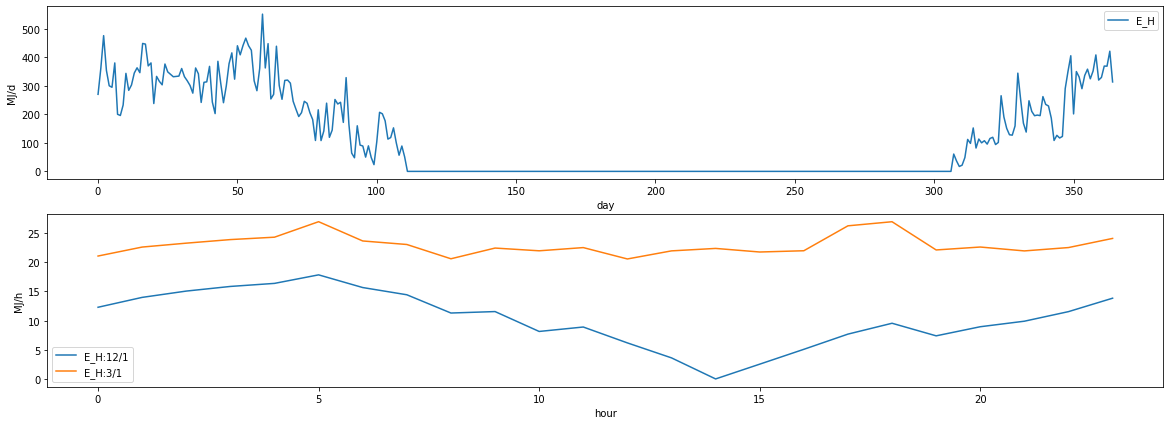

In [37]:
get_each_graph(_E_H_d_t_1)

### 計算条件2

- 主居室、その他居室の暖房設備を温水暖房用ファンコンベクターに変更
- 温水暖房機の種類を石油潜熱回収型温水暖房機に変更
- 断熱配管を評価しないに変更
- 配管が通過する空間を評価しないに変更

In [38]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR['type'] = '温水暖房用ファンコンベクター'
H_OR['type'] = '温水暖房用ファンコンベクター'
H_HS['type'] = '石油潜熱回収型温水暖房機'
del H_HS['e_rtd_hs']
H_HS['pipe_insulation'] = False
H_HS['underfloor_pipe_insulation'] = False

_E_H_d_t_2 = calc_results(house_base, H_MR, H_OR, H_HS)


E_H:19978.860846061947MJ/y


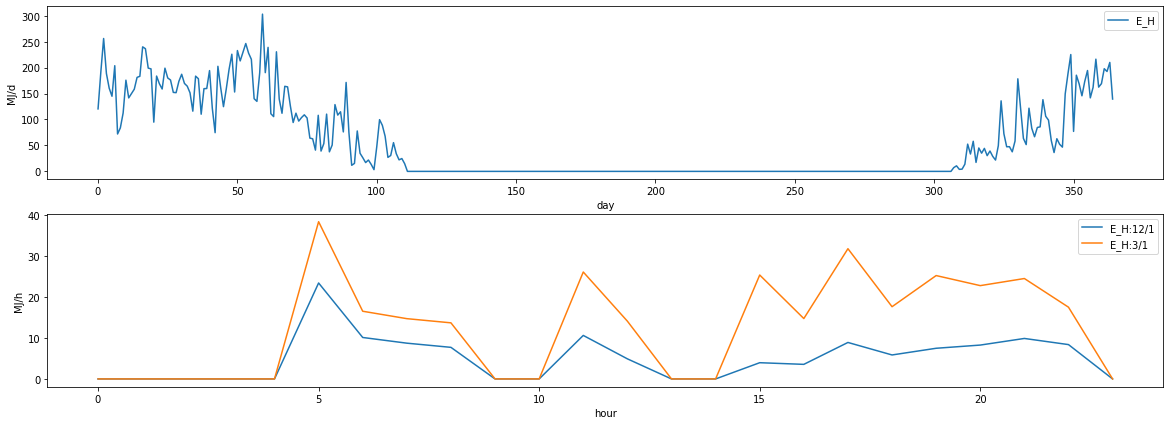

In [39]:
get_each_graph(_E_H_d_t_2)

### 計算条件3

- 主居室、その他居室の暖房設備を温水暖房用床暖房に変更
- 主居室の敷設率を0.3、仮想床の床面積を除いた敷設率を0.5、上面放熱率（床の断熱）を0.9に変更
- その他居室の敷設率を0.65、上面放熱率（床の断熱）を0.7に変更
- 温水暖房機の種類をガス従来型温水暖房機、エネルギー消費効率を0.81に変更

In [40]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.3, 'r_dash_Af': 0.5, 'r_up': 0.9}
H_OR = {'type': '温水暖房用床暖房', 'r_Af': 0.65, 'r_up': 0.7}
H_HS = {'type': 'ガス従来型温水暖房機', 'e_rtd_hs': 0.81, 'pipe_insulation': True, 'underfloor_pipe_insulation': True}

_E_H_d_t_3 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:44175.389744659886MJ/y


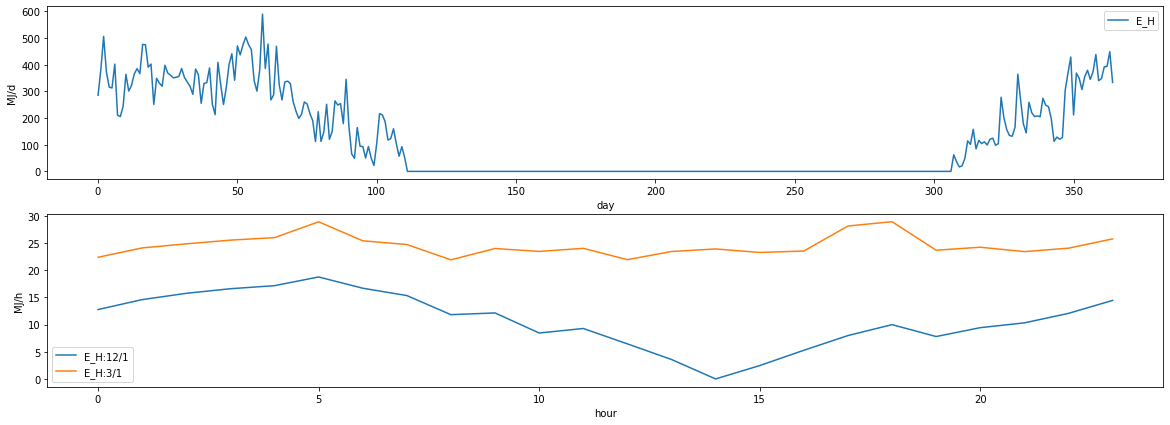

In [41]:
get_each_graph(_E_H_d_t_3)

### 計算条件4

- 主居室の暖房設備を温水暖房用床暖房に変更
- 主居室の敷設率を0.4、上面放熱率（床の断熱）を0.9に変更
- その他居室の暖房設備をルームエアコンディショナーに変更
- その他居室のエネルギー消費効率を「ろ」に変更
- 温水暖房機の種類をガス潜熱回収型温水暖房機、エネルギー消費効率を0.87に変更

In [42]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
H_HS['type'] = 'ガス潜熱回収型温水暖房機'
H_HS['e_rtd_hs'] = 0.87

_E_H_d_t_4 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:14408.10505746133MJ/y


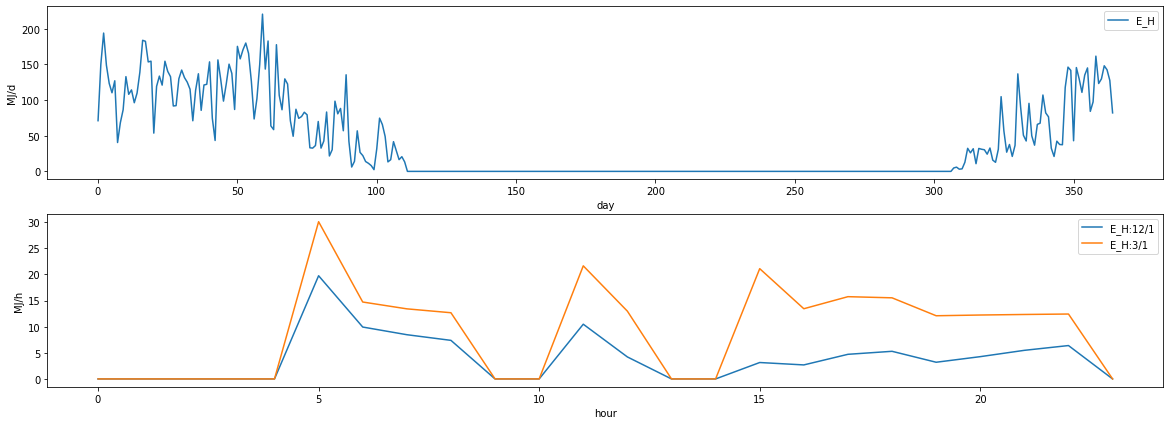

In [43]:
get_each_graph(_E_H_d_t_4)

### 計算条件5

- 主居室の暖房設備を温水暖房用床暖房に変更
- 主居室の敷設率を0.4、上面放熱率（床の断熱）を0.9に変更
- その他居室の暖房設備をルームエアコンディショナーに変更
- その他居室のエネルギー消費効率を「ろ」に変更
- 温水暖房機の種類を電気ヒートポンプ温水暖房機に変更

In [44]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
H_HS['type'] = '電気ヒートポンプ温水暖房機'

_E_H_d_t_5 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:14716.370807563266MJ/y


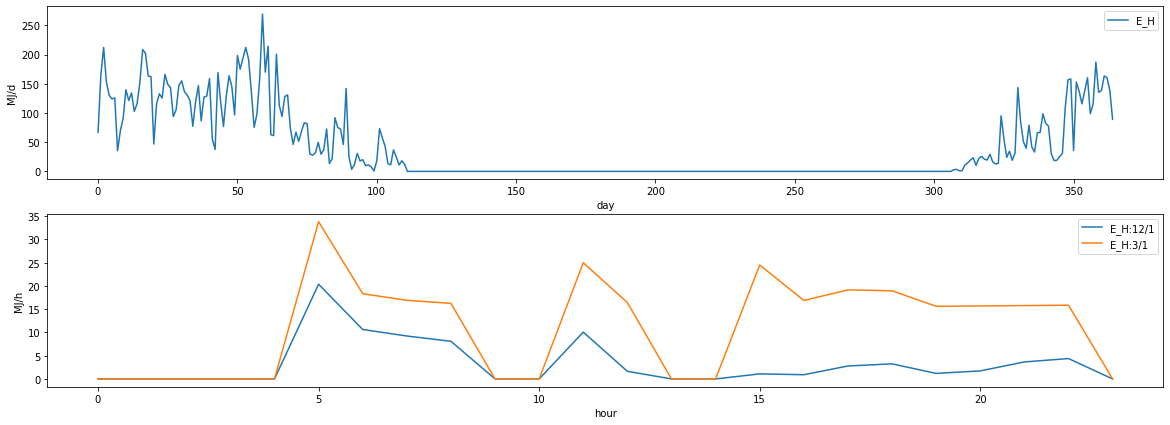

In [45]:
get_each_graph(_E_H_d_t_5)

### 計算条件6

- 主居室の暖房設備を温水暖房用床暖房に変更
- 主居室の敷設率を0.4、上面放熱率（床の断熱）を0.9に変更
- その他居室の暖房設備をルームエアコンディショナーに変更
- その他居室のエネルギー消費効率を「ろ」に変更
- 温水暖房機の種類を電気ヒーター温水暖房機に変更

In [46]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
H_HS['type'] = '電気ヒーター温水暖房機'

_E_H_d_t_6 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:27521.5116359412MJ/y


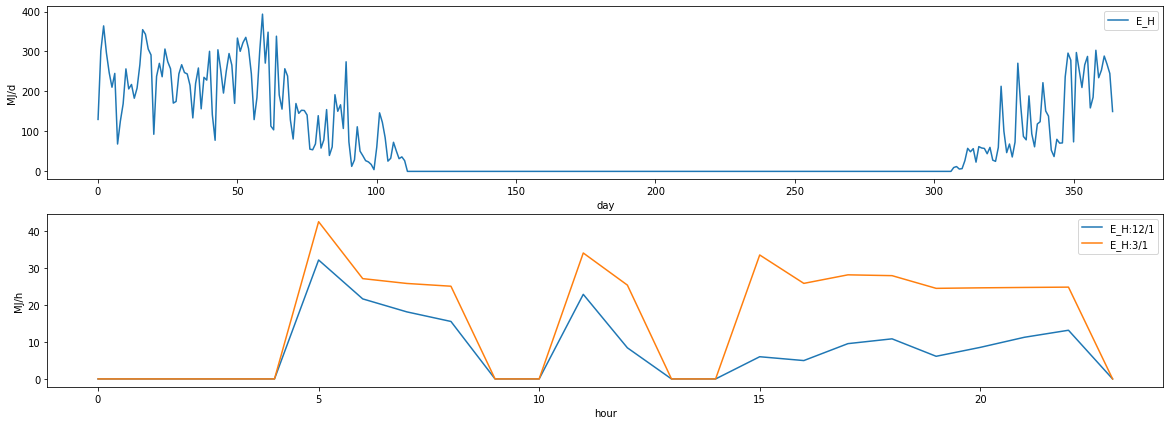

In [47]:
get_each_graph(_E_H_d_t_6)

### 計算条件7

- 主居室の暖房設備を温水暖房用床暖房に変更
- 主居室の敷設率を0.4、上面放熱率（床の断熱）を0.9に変更
- その他居室の暖房設備をルームエアコンディショナーに変更
- その他居室のエネルギー消費効率を「ろ」に変更
- 温水暖房機の種類を地中熱ヒートポンプ温水暖房機、熱交換器タイプを5に変更

In [48]:
house_base, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_up': 0.9}
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
H_HS['type'] = '地中熱ヒートポンプ温水暖房機'
H_HS['HeatExchanger'] = '5'

_E_H_d_t_7 = calc_results(house_base, H_MR, H_OR, H_HS)

E_H:12911.713155884903MJ/y


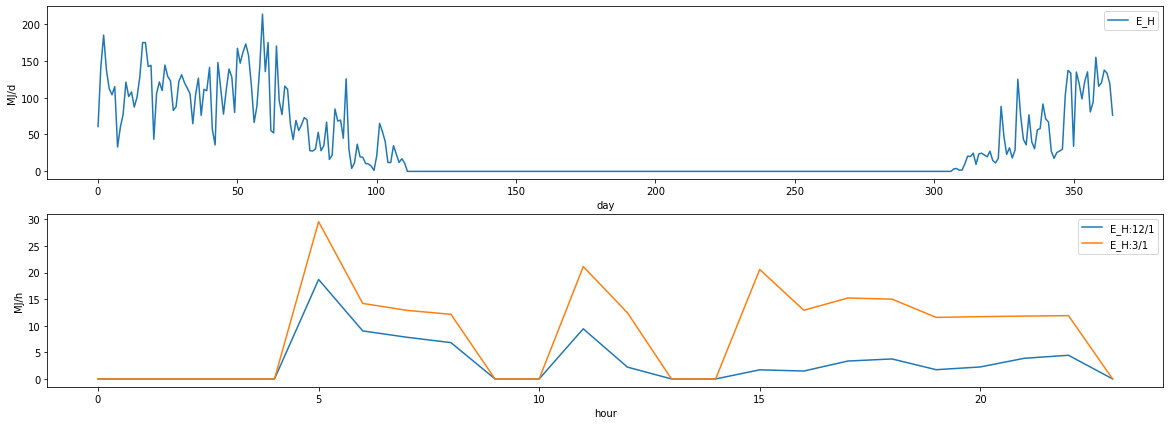

In [49]:
get_each_graph(_E_H_d_t_7)

## 比較

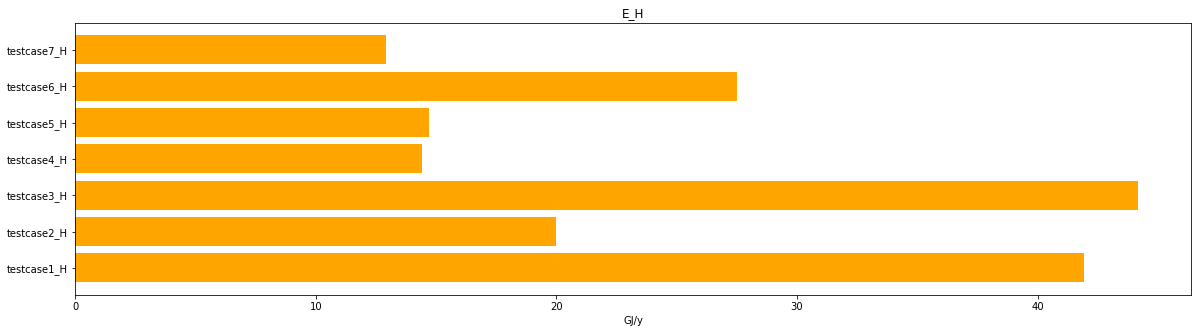

In [50]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(_E_H_d_t_1)/1000, "testcase2_H": np.sum(_E_H_d_t_2)/1000, "testcase3_H": np.sum(_E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(_E_H_d_t_4)/1000, "testcase5_H": np.sum(_E_H_d_t_5)/1000, "testcase6_H": np.sum(_E_H_d_t_6)/1000,
         "testcase7_H": np.sum(_E_H_d_t_7)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()